# Deep Q-Network

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Import environment
from environments.pendulum import pendulum

env = pendulum(mass=1, length=1, gravity=9.81)
env.step_size = 0.05

In [4]:
# Define reward function
quadratic_cost = np.diag([10, 1])/500
env.reward = lambda : -100 if env.terminal() else -float(env.x@quadratic_cost@env.x)

# Define legal actions 
env.actions = lambda : np.array([-5, 0, 5])

# Define terminal state
env.terminal = lambda : np.abs(env.x[0]) > 3*np.pi

# Define state variabels
mod = lambda theta : ((theta/np.pi - 1) % 2)*np.pi - np.pi
env.state = lambda : np.array([np.sin(env.x[0]), np.cos(env.x[0]), env.x[0], env.x[1]])

## The deep q network class
For the the deep q network we have a input state which is sendt into a hidden layer. After the hidden layer the network is split into an advange and value sub network which then are recombined to compute the final Q values. The reason for splitting the network in two is to speed up and stabilize training by not having the network have to compute the value for each action, but only the advantage that an action has over the other actions in a state. This can be thought of as computing $Q(s, a)$ as: 

$$
    Q(s, a) = V(s) + A(s, a)
$$
where $V$ is the value of the state and $A$ is the advantage of an action in the state. 

In [5]:
class Qnetwork():
    def __init__(self, state_size, action_size, hidden_layer_shape = [8, 16], learning_rate = 1e-3, dropout = 0.5):
        self.is_training = False
        
        # Here we create the input of the network, and a hidden layer
        self.state_in = tf.placeholder(shape=[None,state_size],dtype=tf.float32)
        self.hidden = slim.stack(inputs = self.state_in,
                                 layer = slim.fully_connected, 
                                 stack_args = hidden_layer_shape,
                                 activation_fn = tf.nn.relu)
        
        self.dropout = tf.layers.dropout(self.hidden, rate = dropout, training = self.is_training)
        # We take the input state and split into a value and advangage sub network
        self.advantage = slim.fully_connected(self.dropout, action_size, activation_fn = None)
        self.value = slim.fully_connected(self.dropout, 1, activation_fn = None)
        
        # We then combine the two sub netorks to get our final Q-values.
        self.Q_out = self.value + tf.subtract(self.advantage,tf.reduce_mean(self.advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Q_out,1)
        
        # We define the loss as the sum of squares difference between the target and prediction Q values.
        self.target_Q = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,action_size,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Q_out, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.target_Q - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        self.updateModel = self.trainer.minimize(self.loss)
        
    
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

## Experience replay buffer
The idea behind the experience replay buffer is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. By keeping the experiences we draw random, we prevent the network from only learning about what it is immediately doing in the environment, and allow it to learn from a more varied array of past experiences. The experience is stored as a tuple $[s, a, r, s']$ where $s$ is the state we are in, $a$ is the action we take, $r$ is the reward we get, and $s'$ is the state we end up in. 

In [6]:
import random
class experience_buffer():
    def __init__(self, buffer_size = 1000000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [23]:
batch_size = 32                         # Number of experiences to use for each training step.
update_freq = 4                         # The frequency at which training is performed
gamma = 0.99                            # Discount factor for the reward
epsilon_final = 0.9                     # Final value of epsilon greedy 
epsilon_start = 0.3                     # Start value of epsilon greedy
num_episodes = 10000                    # How many episodes of game environment to train network with.
pre_train_steps = 1000                  # How many steps of random actions before training begins.
max_episode_length = 200                # The max allowed length of our episode.
print_interval = 100                    # How often we print the training progress
load_model = False                       # Whether to load a saved model.
path = "./weights/"                     # The path to save our model to.
h_shape = [256, 512, 1024, 512]         # The shape of the hidden layers before splitting it into Advantage and Value sub networks.
tau = 0.001                             # Rate to update target network toward primary network

In [24]:
tf.reset_default_graph()
mainQN = Qnetwork(len(env.state()), len(env.actions()))
targetQN = Qnetwork(len(env.state()), len(env.actions()))
init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
if load_model == False:
    reward_list = []
total_steps = 0

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        epsilon = (epsilon_final - epsilon_start)*i/num_episodes + epsilon_start
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        theta =  (2*np.random.random() - 1)*np.pi
        state = env.init([theta,0])
        done = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_episode_length and env.terminal() == False:
            # Choose an action (epsilon greedy)
            if np.random.rand(1) > epsilon or total_steps < pre_train_steps:
                a_idx = np.random.randint(0,len(env.actions()))
            else:
                a_idx = sess.run(mainQN.predict,feed_dict={mainQN.state_in:[state]})[0]
                
            # Apply action and observe reward and next state
            next_state = env.step(env.actions()[a_idx])
            reward = env.reward()
            done = env.terminal()
            total_steps += 1
            
            # Save experience to replay buffer
            episodeBuffer.add(np.reshape(np.array([state,a_idx,reward,next_state,done]),[1,5]))
        
            if total_steps > pre_train_steps and total_steps % (update_freq) == 0:
                # set trainig mode
                mainQN.is_training = True
                
                # Get a random batch of experiences.
                trainBatch = myBuffer.sample(batch_size)
                
                #Below we perform the Double-DQN update to the target Q-values
                Q1 = sess.run(mainQN.predict,feed_dict={mainQN.state_in:np.vstack(trainBatch[:,3])})
                Q2 = sess.run(targetQN.Q_out,feed_dict={targetQN.state_in:np.vstack(trainBatch[:,3])})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (gamma*doubleQ*end_multiplier)
                #Update the network with our target values.
                _ = sess.run(mainQN.updateModel, feed_dict={mainQN.state_in: np.vstack(trainBatch[:,0]),
                                                            mainQN.target_Q: targetQ,
                                                            mainQN.actions: trainBatch[:,1]})
                updateTarget(targetOps,sess)
                mainQN.is_training = False
            
            rAll += reward
            state = next_state
            j+=1
        
        myBuffer.add(episodeBuffer.buffer)
        reward_list.append(rAll)
        #Periodically save the model. 
        if i % (num_episodes//10) == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if i % print_interval == 0:
            print("Episode: {}, Mean reward: {}, Epsilon: {}".format(i, np.mean(reward_list[-print_interval:]), epsilon))
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')

Saved Model
Episode: 0, Mean reward: -54.905130620455104, Epsilon: 0.2
Saved Model
Episode: 100, Mean reward: -94.42574155011778, Epsilon: 0.27
Saved Model
Episode: 200, Mean reward: -76.26125742299865, Epsilon: 0.34
Saved Model
Episode: 300, Mean reward: -65.65029635524034, Epsilon: 0.41000000000000003
Saved Model
Episode: 400, Mean reward: -65.22927572270606, Epsilon: 0.48000000000000004
Saved Model
Episode: 500, Mean reward: -48.62687071823855, Epsilon: 0.55
Saved Model
Episode: 600, Mean reward: -49.90822282692224, Epsilon: 0.62
Saved Model
Episode: 700, Mean reward: -36.12496232382391, Epsilon: 0.69
Saved Model
Episode: 800, Mean reward: -27.8817551588335, Epsilon: 0.76
Saved Model
Episode: 900, Mean reward: -32.84864599097186, Epsilon: 0.8300000000000001


## Show training progress

In [9]:
from ipywidgets import widgets

def plot_moving_average(window_size):
    interval = reward_list
    window= np.ones(int(window_size))/float(window_size)
    data = np.convolve(interval, window, 'valid')
    plt.plot(data)
    plt.show()

slider = widgets.interact(plot_moving_average, window_size=(1, 1000, 1))

## Simulation results
The code below will render the cart pnedulum, you may get the error that ffmpg is not installed, for anaconda users this can be done by 
```bash
conda install -c conda-forge ffmpeg
```

In [29]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 200
X = np.zeros((n_steps, len(env.x)))
U = np.zeros((n_steps))
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.all_model_checkpoint_paths[-2])
    theta = (2*np.random.random() - 1)*0.1
    state = env.init([np.pi, 0])
    for step in range(n_steps):
        X[step, :] = env.x
        a_idx, Q = sess.run([mainQN.predict, mainQN.Q_out],feed_dict={mainQN.state_in:[state]})
        state = env.step(env.actions()[a_idx])
        U[step] = env.actions()[a_idx]

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
animate = lambda i: line.set_data([0, np.sin(X[i, 0])],[0, np.cos(X[i, 0])])

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)

INFO:tensorflow:Restoring parameters from ./weights/model-9000.ckpt


In [11]:
HTML(anim.to_html5_video())

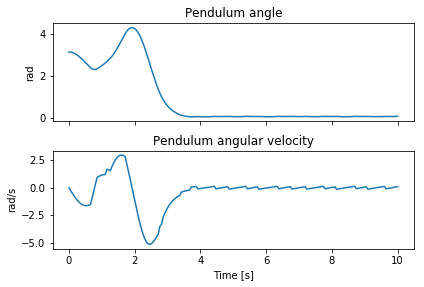

In [30]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
names = ["Pendulum angle", "Pendulum angular velocity"]
units = ["rad", "rad/s"]
fig, axarr = plt.subplots(2, sharex=True)
for i in range(2):
    axarr[i].plot(t, X[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()

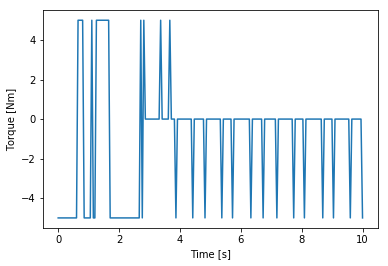

In [21]:
# Plot trajectory
t = np.linspace(0, n_steps*env.step_size, X.shape[0])
plt.figure()
plt.plot(t, U)
plt.ylabel("Torque [Nm]")
plt.xlabel("Time [s]")
plt.show()

INFO:tensorflow:Restoring parameters from ./weights/model-9000.ckpt


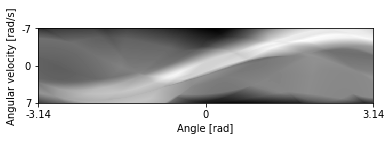

In [36]:

from matplotlib import pyplot as plt

img = np.zeros((140, 628))
with tf.Session() as sess:
    ckpt = tf.train.get_checkpoint_state(path)
    file = saver.restore(sess,ckpt.all_model_checkpoint_paths[-2])
    value = lambda state: np.max(sess.run(mainQN.Q_out,feed_dict={mainQN.state_in:state}), axis=1)
    angles = np.linspace(-np.pi, np.pi, 628)
    for i, y in enumerate(np.linspace(-7, 7, 140)):
        x = np.column_stack((np.sin(angles), np.cos(angles), angles,  y*np.ones((628))))
        img[i, :] = value(x)

plt.figure()
plt.imshow(img, cmap="gray")
plt.xticks([0, 314, 628],[-3.14, 0, 3.14])
plt.yticks([0, 70, 140], [-7, 0, 7])
plt.xlabel("Angle [rad]")
plt.ylabel("Angular velocity [rad/s]")
plt.show()